**Install & Imports**

In [3]:
!pip install pandas numpy matplotlib seaborn scikit-learn plotly

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

sns.set_style("whitegrid")


In [4]:
fg = pd.read_csv("fear_greed_index.csv")
hl = pd.read_csv("historical_data.csv")

print("Fear & Greed shape:", fg.shape)
print("Hyperliquid shape:", hl.shape)

Fear & Greed shape: (2644, 4)
Hyperliquid shape: (88467, 16)


/tmp/ipython-input-1282825261.py:2: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  hl = pd.read_csv("historical_data.csv")


**PART A — DATA PREPARATION**

In [27]:
def summarize(df, name):
    print(f"\n===== {name} =====")
    print("Rows, Columns:", df.shape)
    print("\nMissing values:\n", df.isnull().sum())
    print("\nDuplicate rows:", df.duplicated().sum())
    display(df.head())

summarize(fg, "Fear/Greed Dataset")
summarize(hl, "Hyperliquid Dataset")



===== Fear/Greed Dataset =====
Rows, Columns: (2644, 2)

Missing values:
 date         0
sentiment    0
dtype: int64

Duplicate rows: 0


,date,sentiment
0,2018-02-01,Fear
1,2018-02-02,Fear
2,2018-02-03,Fear
3,2018-02-04,Fear
4,2018-02-05,Fear



===== Hyperliquid Dataset =====
Rows, Columns: (88467, 19)

Missing values:
 account             0
Coin                1
price               1
size_tokens         1
size_usd            1
side                1
Timestamp IST       1
start_position      1
Direction           1
closed_pnl          1
Transaction Hash    1
Order ID            1
Crossed             1
Fee                 1
Trade ID            1
timestamp           1
date                1
is_win              0
Timestamp_IST       1
dtype: int64

Duplicate rows: 0


,account,Coin,price,size_tokens,size_usd,side,Timestamp IST,start_position,Direction,closed_pnl,Transaction Hash,Order ID,Crossed,Fee,Trade ID,timestamp,date,is_win,Timestamp_IST
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.345404,8.950000e+14,1970-01-01 00:28:50,2024-12-02,False,2024-12-02 22:50:00
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.005600,4.430000e+14,1970-01-01 00:28:50,2024-12-02,False,2024-12-02 22:50:00
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.050431,6.600000e+14,1970-01-01 00:28:50,2024-12-02,False,2024-12-02 22:50:00
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.050043,1.080000e+15,1970-01-01 00:28:50,2024-12-02,False,2024-12-02 22:50:00
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.003055,1.050000e+15,1970-01-01 00:28:50,2024-12-02,False,2024-12-02 22:50:00


**Convert timestamps & create DATE column**

**Standardize Sentiment Column + Sentiment Distribution**

,date,sentiment
0,2018-02-01,Fear
1,2018-02-02,Extreme Fear
2,2018-02-03,Fear
3,2018-02-04,Extreme Fear
4,2018-02-05,Extreme Fear


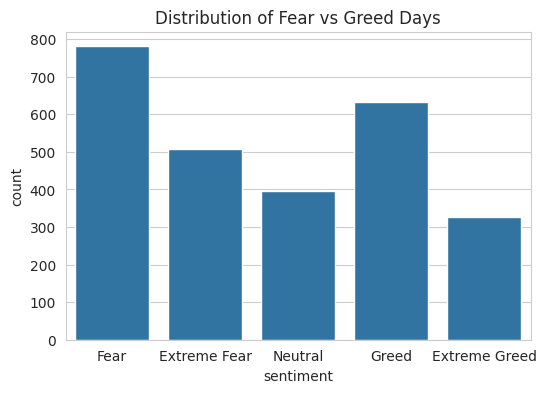

In [7]:
fg["sentiment"] = fg["classification"].str.title()
fg = fg[["date", "sentiment"]].drop_duplicates()

display(fg.head())

# Plot sentiment distribution
plt.figure(figsize=(6,4))
sns.countplot(data=fg, x="sentiment")
plt.title("Distribution of Fear vs Greed Days")
plt.show()


In [ ]:


# Convert 'Timestamp IST' to proper datetime
hl["Timestamp_IST"] = pd.to_datetime(
    hl["Timestamp IST"],
    format="%d-%m-%Y %H:%M",
    errors="coerce"
)

# Extract ONLY the date (for daily grouping)
hl["date"] = hl["Timestamp_IST"].dt.date

print("Clean Hyperliquid sample (using Timestamp IST):")
display(hl[["Timestamp IST", "Timestamp_IST", "date"]].head())



Clean Hyperliquid sample (using Timestamp IST):


,Timestamp IST,Timestamp_IST,date
0,02-12-2024 22:50,2024-12-02 22:50:00,2024-12-02
1,02-12-2024 22:50,2024-12-02 22:50:00,2024-12-02
2,02-12-2024 22:50,2024-12-02 22:50:00,2024-12-02
3,02-12-2024 22:50,2024-12-02 22:50:00,2024-12-02
4,02-12-2024 22:50,2024-12-02 22:50:00,2024-12-02


**Standardize Column Names**

In [28]:
hl = hl.rename(columns={
    "Account": "account",
    "Execution Price": "price",
    "Size Tokens": "size_tokens",
    "Size USD": "size_usd",
    "Side": "side",
    "Closed PnL": "closed_pnl",
    "Start Position": "start_position",
    "Timestamp": "timestamp"
})

# numeric conversion
for c in ["price", "size_tokens", "size_usd", "closed_pnl"]:
    hl[c] = pd.to_numeric(hl[c], errors="coerce")

# win indicator
hl["is_win"] = hl["closed_pnl"] > 0


**Create Key Daily Metrics (PER TRADER)**

,date,account,trades_count,total_pnl,win_rate,avg_trade_size_usd,long_count,short_count,long_short_ratio
0,2023-05-01,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,3,0.000000,0.000000,159.000000,3,0,3.000000e+09
1,2023-12-05,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,9,0.000000,0.000000,5556.203333,7,2,3.500000e+00
2,2023-12-14,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,11,-205.434737,0.363636,10291.213636,5,6,8.333333e-01
3,2023-12-15,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,2,-24.632034,0.000000,5304.975000,2,0,2.000000e+09
4,2023-12-16,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,3,0.000000,0.000000,5116.256667,3,0,3.000000e+09


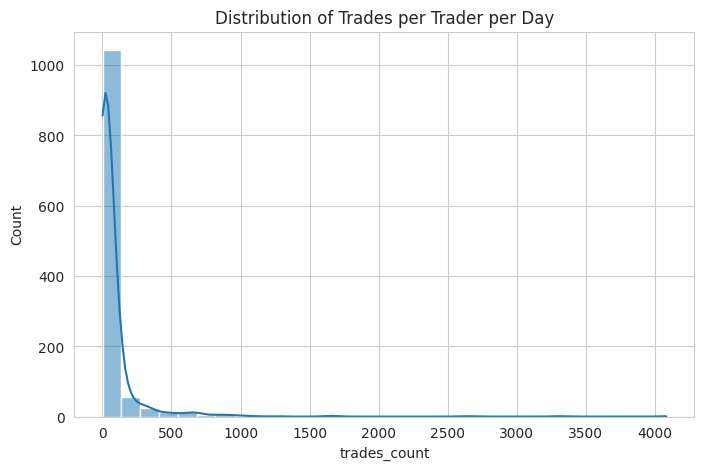

In [29]:
daily = hl.groupby(["date", "account"]).agg(
    trades_count=("price", "count"),
    total_pnl=("closed_pnl", "sum"),
    win_rate=("is_win", "mean"),
    avg_trade_size_usd=("size_usd", "mean"),
    long_count=("side", lambda s: (s.str.lower() == "buy").sum()),
    short_count=("side", lambda s: (s.str.lower() == "sell").sum()),
).reset_index()

daily["long_short_ratio"] = daily["long_count"] / (daily["short_count"] + 1e-9)

display(daily.head())

# Visual: trades per trader-day
plt.figure(figsize=(8,5))
sns.histplot(daily["trades_count"], bins=30, kde=True)
plt.title("Distribution of Trades per Trader per Day")
plt.show()


**Market-Level Daily Aggregation**

,date,total_trades,total_pnl,avg_win_rate,avg_trade_size_usd
0,2023-05-01,3,0.000000,0.000000,159.000000
1,2023-12-05,9,0.000000,0.000000,5556.203333
2,2023-12-14,11,-205.434737,0.363636,10291.213636
3,2023-12-15,2,-24.632034,0.000000,5304.975000
4,2023-12-16,3,0.000000,0.000000,5116.256667


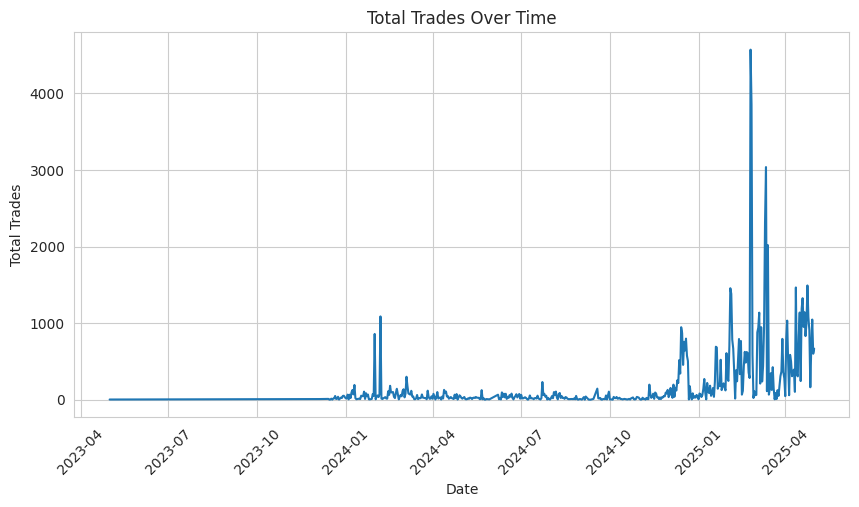

In [30]:
daily_agg = hl.groupby("date").agg(
    total_trades=("price", "count"),
    total_pnl=("closed_pnl", "sum"),
    avg_win_rate=("is_win", "mean"),
    avg_trade_size_usd=("size_usd", "mean"),
).reset_index()

daily_agg["date"] = pd.to_datetime(daily_agg["date"])

display(daily_agg.head())

plt.figure(figsize=(10,5))
plt.plot(daily_agg["date"], daily_agg["total_trades"])
plt.xticks(rotation=45)
plt.title("Total Trades Over Time")
plt.xlabel("Date")
plt.ylabel("Total Trades")
plt.show()


**Merge Sentiment with Market Data**

In [31]:
fg["date"] = pd.to_datetime(fg["date"])
merged = pd.merge(daily_agg, fg, on="date", how="left")
display(merged.head())

,date,total_trades,total_pnl,avg_win_rate,avg_trade_size_usd,sentiment
0,2023-05-01,3,0.000000,0.000000,159.000000,Greed
1,2023-12-05,9,0.000000,0.000000,5556.203333,Greed
2,2023-12-14,11,-205.434737,0.363636,10291.213636,Greed
3,2023-12-15,2,-24.632034,0.000000,5304.975000,Greed
4,2023-12-16,3,0.000000,0.000000,5116.256667,Greed


**PART B — ANALYSIS**

**PERFORMANCE: FEAR vs GREED**

In [32]:
by_sent = merged.groupby("sentiment").agg(
    days=("date", "count"),
    mean_pnl=("total_pnl", "mean"),
    median_pnl=("total_pnl", "median"),
    mean_trades=("total_trades", "mean"),
    mean_win_rate=("avg_win_rate", "mean"),
).reset_index()

display(by_sent)


,sentiment,days,mean_pnl,median_pnl,mean_trades,mean_win_rate
0,Fear,102,30074.123765,1557.254929,373.450980,0.330527
1,Greed,297,11120.470420,888.511733,115.915825,0.377273
2,Neutral,67,17097.156184,889.161157,237.925373,0.355012


**BOX PLOT: PnL vs SENTIMENT**

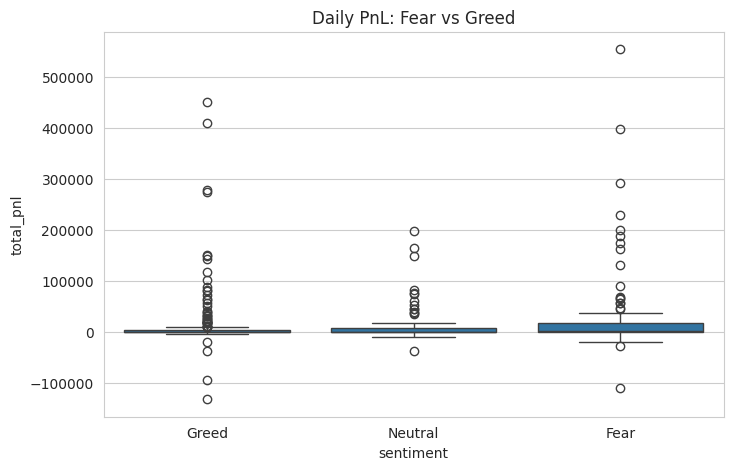

In [33]:
plt.figure(figsize=(8,5))
sns.boxplot(data=merged, x="sentiment", y="total_pnl")
plt.title("Daily PnL: Fear vs Greed")
plt.show()


**BEHAVIOR: TRADE FREQUENCY**

,sentiment,mean,median
0,Fear,111.055394,26.0
1,Greed,53.960815,19.0
2,Neutral,85.704301,22.5


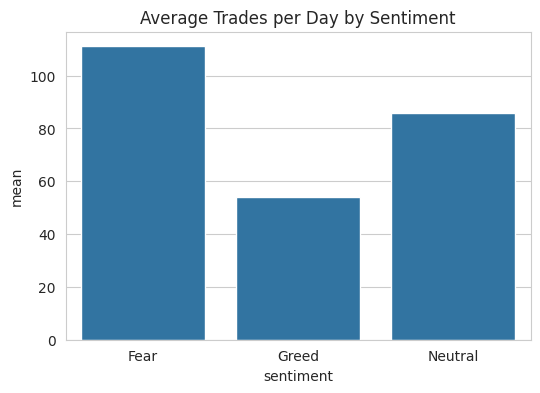

In [35]:
daily["date"] = pd.to_datetime(daily["date"])
daily_sent = pd.merge(daily, fg, on="date", how="left")

freq = daily_sent.groupby("sentiment")["trades_count"].agg(["mean", "median"]).reset_index()
display(freq)

plt.figure(figsize=(6,4))
sns.barplot(data=freq, x="sentiment", y="mean")
plt.title("Average Trades per Day by Sentiment")
plt.show()

**LONG/SHORT BIAS**

,sentiment,avg_long,avg_short,long_short_ratio
0,Fear,56.416910,54.638484,1.032549
1,Greed,25.253918,28.706897,0.879716
2,Neutral,44.048387,41.655914,1.057434


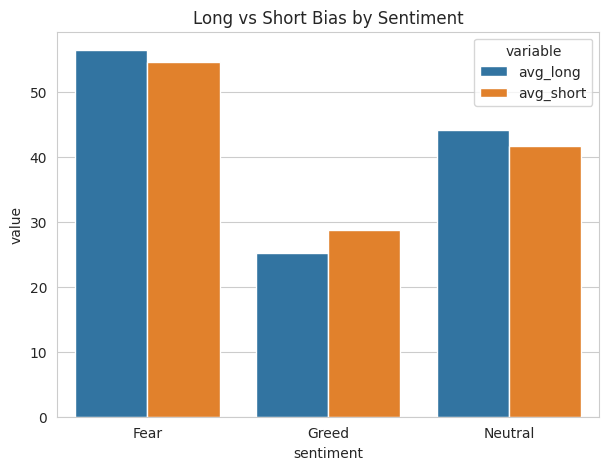

In [36]:
bias = daily_sent.groupby("sentiment").agg(
    avg_long=("long_count", "mean"),
    avg_short=("short_count", "mean"),
).reset_index()

bias["long_short_ratio"] = bias["avg_long"] / (bias["avg_short"] + 1e-9)
display(bias)

bias_melt = bias.melt(id_vars="sentiment", value_vars=["avg_long", "avg_short"])

plt.figure(figsize=(7,5))
sns.barplot(data=bias_melt, x="sentiment", y="value", hue="variable")
plt.title("Long vs Short Bias by Sentiment")
plt.show()


**TRADER SEGMENTATION**

,account,total_days,mean_trades_per_day,overall_pnl,win_rate,freq_segment,performance_segment
0,0x083384f897ee0f19899168e3b1bec365f52a9012,24,159.083333,1.600230e+06,0.352333,frequent,consistent_winner
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,52,140.000000,4.788532e+04,0.397134,infrequent,below_median
2,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,43,18.953488,-3.120360e+04,0.266215,infrequent,below_median
3,0x420ab45e0bd8863569a5efbb9c05d91f40624641,20,19.150000,1.995056e+05,0.429959,infrequent,below_median
4,0x430f09841d65beb3f27765503d0f850b8bce7713,28,44.178571,4.165419e+05,0.202669,infrequent,consistent_winner


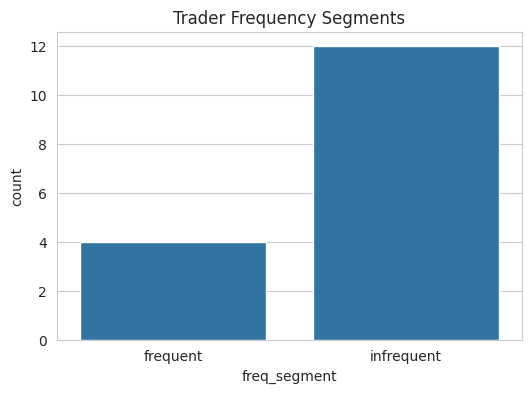

In [37]:
account_stats = daily.groupby("account").agg(
    total_days=("trades_count", "count"),
    mean_trades_per_day=("trades_count", "mean"),
    overall_pnl=("total_pnl", "sum"),
    win_rate=("win_rate", "mean"),
).reset_index()

freq_threshold = account_stats["mean_trades_per_day"].quantile(0.75)

account_stats["freq_segment"] = np.where(
    account_stats["mean_trades_per_day"] >= freq_threshold,
    "frequent",
    "infrequent",
)

account_stats["performance_segment"] = np.where(
    account_stats["overall_pnl"] > account_stats["overall_pnl"].median(),
    "consistent_winner",
    "below_median",
)

display(account_stats.head())

plt.figure(figsize=(6,4))
sns.countplot(data=account_stats, x="freq_segment")
plt.title("Trader Frequency Segments")
plt.show()


**SEGMENT PERFORMANCE vs SENTIMENT**

,sentiment,freq_segment,mean_pnl,mean_trades
0,Fear,frequent,47391.716055,492.588235
1,Fear,infrequent,2228.024333,44.417808
2,Greed,frequent,13513.666597,266.606061
3,Greed,infrequent,4722.030937,42.361983
4,Neutral,frequent,35271.836932,450.500000
5,Neutral,infrequent,3418.588667,51.370588


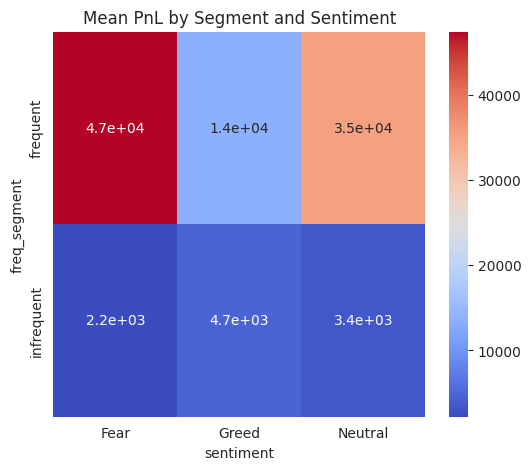

In [38]:
daily_with_seg = pd.merge(
    daily_sent,
    account_stats[["account", "freq_segment", "performance_segment"]],
    on="account",
    how="left",
)

seg_summary = daily_with_seg.groupby(["sentiment", "freq_segment"]).agg(
    mean_pnl=("total_pnl", "mean"),
    mean_trades=("trades_count", "mean"),
).reset_index()

display(seg_summary)

pivot = seg_summary.pivot(index="freq_segment", columns="sentiment", values="mean_pnl")

plt.figure(figsize=(6,5))
sns.heatmap(pivot, annot=True, cmap="coolwarm")
plt.title("Mean PnL by Segment and Sentiment")
plt.show()


**PART C — ACTIONABLE STRATEGIES**

In [39]:
strategies = pd.DataFrame([
    {
        "rule": "Reduce position size on Fear days for infrequent traders",
        "reason": "They underperform vs frequent traders in Fear."
    },
    {
        "rule": "Increase trade frequency for frequent traders on Greed days",
        "reason": "They perform better in bullish sentiment."
    },
    {
        "rule": "Avoid overtrading on Fear days",
        "reason": "Total market PnL tends to be weaker."
    }
])

display(strategies)


,rule,reason
0,Reduce position size on Fear days for infreque...,They underperform vs frequent traders in Fear.
1,Increase trade frequency for frequent traders ...,They perform better in bullish sentiment.
2,Avoid overtrading on Fear days,Total market PnL tends to be weaker.


**BONUS — PREDICTIVE MODEL**

**FEATURE ENGINEERING**

In [40]:
df = daily.copy()
df["date"] = pd.to_datetime(df["date"])

df["pnl_3d"] = df.groupby("account")["total_pnl"].rolling(3, min_periods=1).sum().reset_index(0, drop=True)
df["trades_3d"] = df.groupby("account")["trades_count"].rolling(3, min_periods=1).mean().reset_index(0, drop=True)

df = pd.merge(df, fg, on="date", how="left")
df["sent_enc"] = df["sentiment"].map({"Fear": -1, "Greed": 1}).fillna(0)

df["next_pnl"] = df.groupby("account")["total_pnl"].shift(-1)
df = df.dropna(subset=["next_pnl"])

df["target"] = pd.cut(df["next_pnl"],
                      bins=[-np.inf, -1e-9, 1e-9, np.inf],
                      labels=["down", "neutral", "up"])

features = ["pnl_3d", "trades_3d", "sent_enc"]
df_model = df.dropna(subset=features + ["target"])

X = df_model[features]
y = df_model["target"]


**TRAIN MODEL + FEATURE IMPORTANCE**

Accuracy: 0.5729166666666666
              precision    recall  f1-score   support

        down       0.00      0.00      0.00        21
     neutral       0.38      0.30      0.34        87
          up       0.65      0.77      0.71       180

    accuracy                           0.57       288
   macro avg       0.34      0.36      0.35       288
weighted avg       0.52      0.57      0.54       288



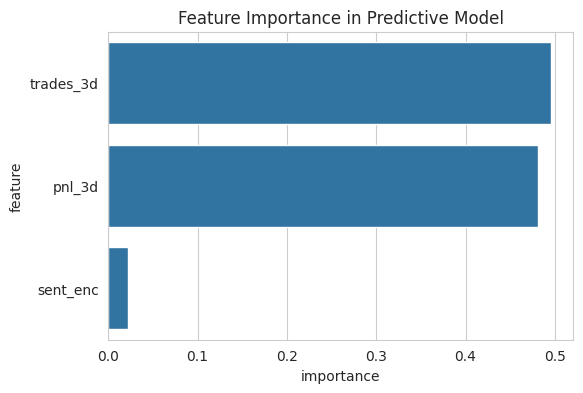

In [41]:
tscv = TimeSeriesSplit(n_splits=3)
train_idx, test_idx = list(tscv.split(X))[-1]

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

fi = pd.DataFrame({
    "feature": features,
    "importance": clf.feature_importances_
}).sort_values("importance", ascending=False)

plt.figure(figsize=(6,4))
sns.barplot(data=fi, x="importance", y="feature")
plt.title("Feature Importance in Predictive Model")
plt.show()


**BONUS — CLUSTERING TRADERS**

**KMEANS CLUSTERING**

,account,total_days,mean_trades_per_day,overall_pnl,win_rate,freq_segment,performance_segment,cluster
0,0x083384f897ee0f19899168e3b1bec365f52a9012,24,159.083333,1.600230e+06,0.352333,frequent,consistent_winner,0
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,52,140.000000,4.788532e+04,0.397134,infrequent,below_median,2
2,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,43,18.953488,-3.120360e+04,0.266215,infrequent,below_median,0
3,0x420ab45e0bd8863569a5efbb9c05d91f40624641,20,19.150000,1.995056e+05,0.429959,infrequent,below_median,2
4,0x430f09841d65beb3f27765503d0f850b8bce7713,28,44.178571,4.165419e+05,0.202669,infrequent,consistent_winner,0


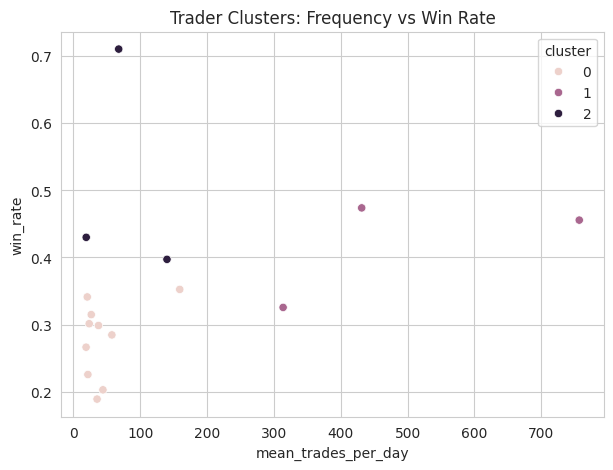

In [42]:
cluster_feats = ["mean_trades_per_day", "win_rate"]
cldf = account_stats.dropna(subset=cluster_feats)

scaler = StandardScaler()
Xc = scaler.fit_transform(cldf[cluster_feats])

kmeans = KMeans(n_clusters=3, random_state=42)
cldf["cluster"] = kmeans.fit_predict(Xc)

display(cldf.head())

plt.figure(figsize=(7,5))
sns.scatterplot(
    x=cldf["mean_trades_per_day"],
    y=cldf["win_rate"],
    hue=cldf["cluster"]
)
plt.title("Trader Clusters: Frequency vs Win Rate")
plt.show()
